In [15]:
import os
import json
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
pplt.rc['reso']='xx-hi'
pplt.rc['figure.dpi'] = 100
warnings.filterwarnings('ignore')

In [16]:
with open('/global/cfs/cdirs/m4334/sferrett/monsoon-kernels/scripts/nn/configs.json','r',encoding='utf-8') as f:
    CONFIGS = json.load(f)
FILEDIR    = CONFIGS['paths']['filedir']    
MODELDIR   = CONFIGS['paths']['modeldir']
RESULTSDIR = CONFIGS['paths']['resultsdir']
MODELS     = CONFIGS['models']

SPLIT      = 'valid'   
PRTHRESH   = 0.01
LANDTHRESH = 0.5
landfrac   = xr.open_dataarray('/global/cfs/cdirs/m4334/sferrett/monsoon-discovery/data/interim/lf.nc')

In [17]:
with xr.open_dataset(os.path.join(FILEDIR,f'{SPLIT}.h5'),engine='h5netcdf') as ds:
    truepr = ds.pr.load()

results = {}
for model in MODELS:
    name,description = model['name'],model['description']
    filename = f'{name}_{SPLIT}_pr.nc'
    filepath = os.path.join(RESULTSDIR,filename)
    if os.path.exists(filepath):
        with xr.open_dataset(filepath,engine='h5netcdf') as ds:
            predpr = ds.pr.load()
        ytrue,ypred = xr.align(truepr,predpr,join='inner')
        results[name] = dict(description=description,ytrue=ytrue,ypred=ypred)
print(f'Found {len(results)} completed models for `{SPLIT}`')

nrows = 2
ncols = 4

Found 7 completed models for `valid`


In [9]:
def get_r2(ytrue,ypred,dims=None,landfrac=None,landthresh=LANDTHRESH):
    dims = list(ytrue.dims) if dims is None else dims
    if landfrac is not None:
        r2values = []
        for mask in [landfrac>=landthresh,landfrac<landthresh]:
            ssres = ((ytrue.where(mask)-ypred.where(mask))**2).sum(dim=dims,skipna=True)
            sstot = ((ytrue.where(mask)-ytrue.where(mask).mean(dim=dims,skipna=True))**2).sum(dim=dims,skipna=True)
            r2values.append(1-ssres/sstot)
        return tuple(r2values)
    ssres = ((ytrue-ypred)**2).sum(dim=dims,skipna=True)
    sstot = ((ytrue-ytrue.mean(dim=dims,skipna=True))**2).sum(dim=dims,skipna=True)
    return 1-ssres/sstot

In [5]:
def plot_density_panels(results,nrows,ncols,globalmin=0,globalmax=14):
    binedges = np.linspace(globalmin,globalmax,57)
    fig,axs  = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=2,share=True)
    axs.format(suptitle='2D Distributions (Validation Set)',
               xlabel=r'Observed (log1p(P)-$\mu$)/$\sigma$',
               ylabel=r'Predicted (log1p(P)-$\mu$)/$\sigma$')
    for ax,(runname,result) in zip(axs,results.items()):
        description = result['description']
        ytrue,ypred = result['ytrue'],result['ypred']
        r2 = get_r2(ytrue,ypred,dims=None)
        ytrueflat = ytrue.values.ravel()
        ypredflat = ypred.values.ravel()
        finite   = np.isfinite(ytrueflat)&np.isfinite(ypredflat)
        hist,_,_ = np.histogram2d(ytrueflat[finite],ypredflat[finite],bins=[binedges,binedges])
        hist = np.ma.masked_where(hist==0,hist)
        im   = ax.pcolormesh(binedges,binedges,hist.T,cmap='ColdHot',vmin=1,vmax=1500,levels=100,extend='max')
        ax.plot([globalmin,globalmax],[globalmin,globalmax],color='k',linewidth=1,linestyle='--')
        text = f'R$^2$ = {r2:.3f}'
        ax.text(0.02,0.98,text,transform=ax.transAxes,va='top',ha='left')
        ax.format(title=description,xlim=(globalmin,globalmax),xticks=3,ylim=(globalmin,globalmax),yticks=3)
    for ax in axs[len(results):]:
        ax.set_axis_off()
        ax.set_visible(False)
    fig.colorbar(im,loc='r',label='Counts',ticks=200)
    pplt.show()

def plot_r2_maps(results,nrows,ncols,landfrac,latlim=(5,25),lonlim=(60,90)):
    fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=3,proj='cyl',share=False)
    axs.format(suptitle='Time-Mean Spatial Distribution of R$^2$',coast=True,latlim=latlim,lonlim=lonlim)
    for ax,(runname,result) in zip(axs,results.items()):
        description = result['description']
        ytrue,ypred = result['ytrue'],result['ypred']
        r2 = get_r2(ytrue,ypred,dims=['time'])
        r2land,r2ocean = get_r2(ytrue,ypred,dims=['time','lat','lon'],landfrac=landfrac)
        r2landmean,r2landstd   = r2land,None
        r2oceanmean,r2oceanstd = r2ocean,None
        im = ax.pcolormesh(r2.lon,r2.lat,r2,cmap='ColdHot',cmap_kw={'left':0.5},vmin=0,vmax=0.6,levels=13,extend='both')
        text = (f'Land R$^2$ = {r2landmean:.3f}\nOcean R$^2$ = {r2oceanmean:.3f}')
        ax.text(0.05,0.95,text,transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round',facecolor='white',alpha=0.8,edgecolor='k'))
        ax.format(title=description)
    for ax in axs[len(results):]:
        ax.set_axis_off()
        ax.set_visible(False)
    fig.colorbar(im,loc='b',label='R$^2$',ticks=0.1)
    pplt.show()

def plot_r2_maps(results,nrows,ncols,landfrac,latlim=(5,25),lonlim=(60,90)):
    fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=3,proj='cyl',share=False)
    axs.format(suptitle='Time-Mean Spatial Distribution of R$^2$',coast=True,latlim=latlim,lonlim=lonlim)
    for ax,(runname,result) in zip(axs,results.items()):
        description = result['description']
        ytrue,ypred = result['ytrue'],result['ypred']
        r2 = get_r2(ytrue,ypred,dims=['time'])
        r2land,r2ocean = get_r2(ytrue,ypred,dims=['time','lat','lon'],landfrac=landfrac)
        r2landmean,r2landstd   = r2land,None
        r2oceanmean,r2oceanstd = r2ocean,None
        im = ax.pcolormesh(r2.lon,r2.lat,r2,cmap='ColdHot',cmap_kw={'left':0.5},vmin=0,vmax=0.6,levels=13,extend='both')
        text = (f'Land R$^2$ = {r2landmean:.3f}\nOcean R$^2$ = {r2oceanmean:.3f}')
        ax.text(0.05,0.95,text,transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round',facecolor='white',alpha=0.8,edgecolor='k'))
        ax.format(title=description)
    for ax in axs[len(results):]:
        ax.set_axis_off()
        ax.set_visible(False)
    fig.colorbar(im,loc='b',label='R$^2$',ticks=0.1)
    pplt.show()

def plot_r2_diff_maps(results,nrows,ncols,landfrac,latlim=(5,25),lonlim=(60,90)):
    ytruebase,ypredbase = results['baseline_full']['ytrue'],results['baseline_full']['ypred']
    otheritems = [(runname,result) for runname,result in results.items() if runname!='baseline_full' and 'vertical' in runname]
    r2base = get_r2(ytruebase,ypredbase,dims=['time'])
    diffs  = []
    for runname,result in otheritems:
        ytrue,ypred = result['ytrue'],result['ypred']
        r2 = get_r2(ytrue,ypred,dims=['time'])
        diffs.append(r2-r2base)
    fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=3,proj='cyl',share=False)
    axs.format(suptitle='Time-Mean ΔR$^2$ (Model - Baseline)',coast=True,latlim=latlim,lonlim=lonlim)
    im = None
    for ax,(runname,result),r2diff in zip(axs,otheritems,diffs):
        description = result['description']
        ytrue,ypred = result['ytrue'],result['ypred']
        im = ax.contourf(r2diff.lon,r2diff.lat,r2diff,cmap='ColdHot',vmin=-0.2,vmax=0.05,levels=13,extend='both')
        ax.format(title=description)
    for ax in axs[len(otheritems):]:
        ax.set_axis_off()
        ax.set_visible(False)
    fig.colorbar(im,loc='b',label='ΔR$^2$',ticks=0.1)
    pplt.show()

def plot_r2_bars(results):
    labels,r2s = [],[]
    for runname,result in results.items():
        otheritems = [(runname,result) for runname,result in results.items() if runname=='baseline_full' or 'vertical' in runname]
        description = result['description']
        ytrue,ypred = result['ytrue'],result['ypred']
        r2 = get_r2(ytrue,ypred,dims=None)
        labels.append(description)
        r2s.append(r2)
    fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=4,refheight=2)
    ax.format(suptitle='NN Skill',xlabel='R$^2$',ylabel='')
    ax.barh(labels,r2s,color='red6',capsize=3)
    pplt.show()

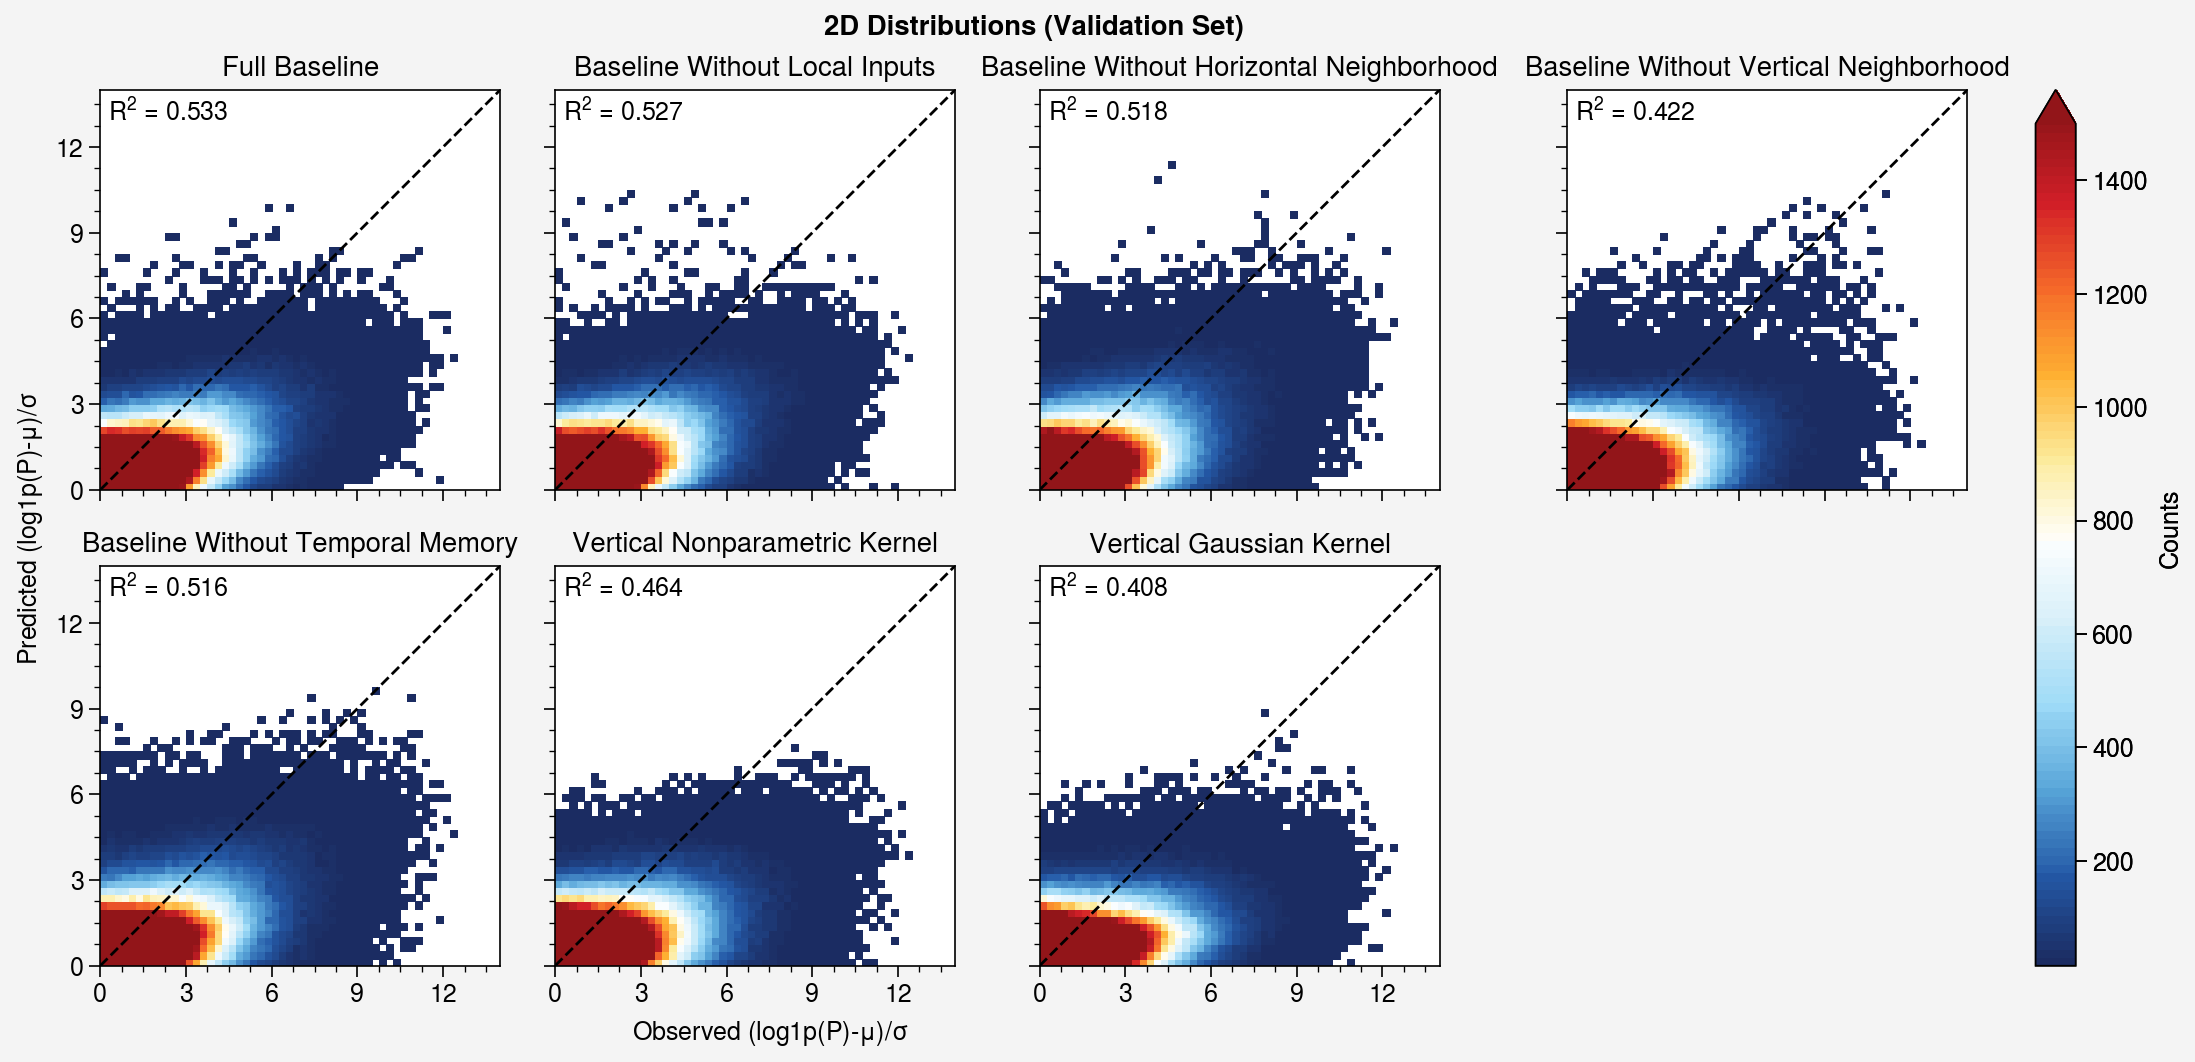

In [21]:
plot_density_panels(results,nrows,ncols)

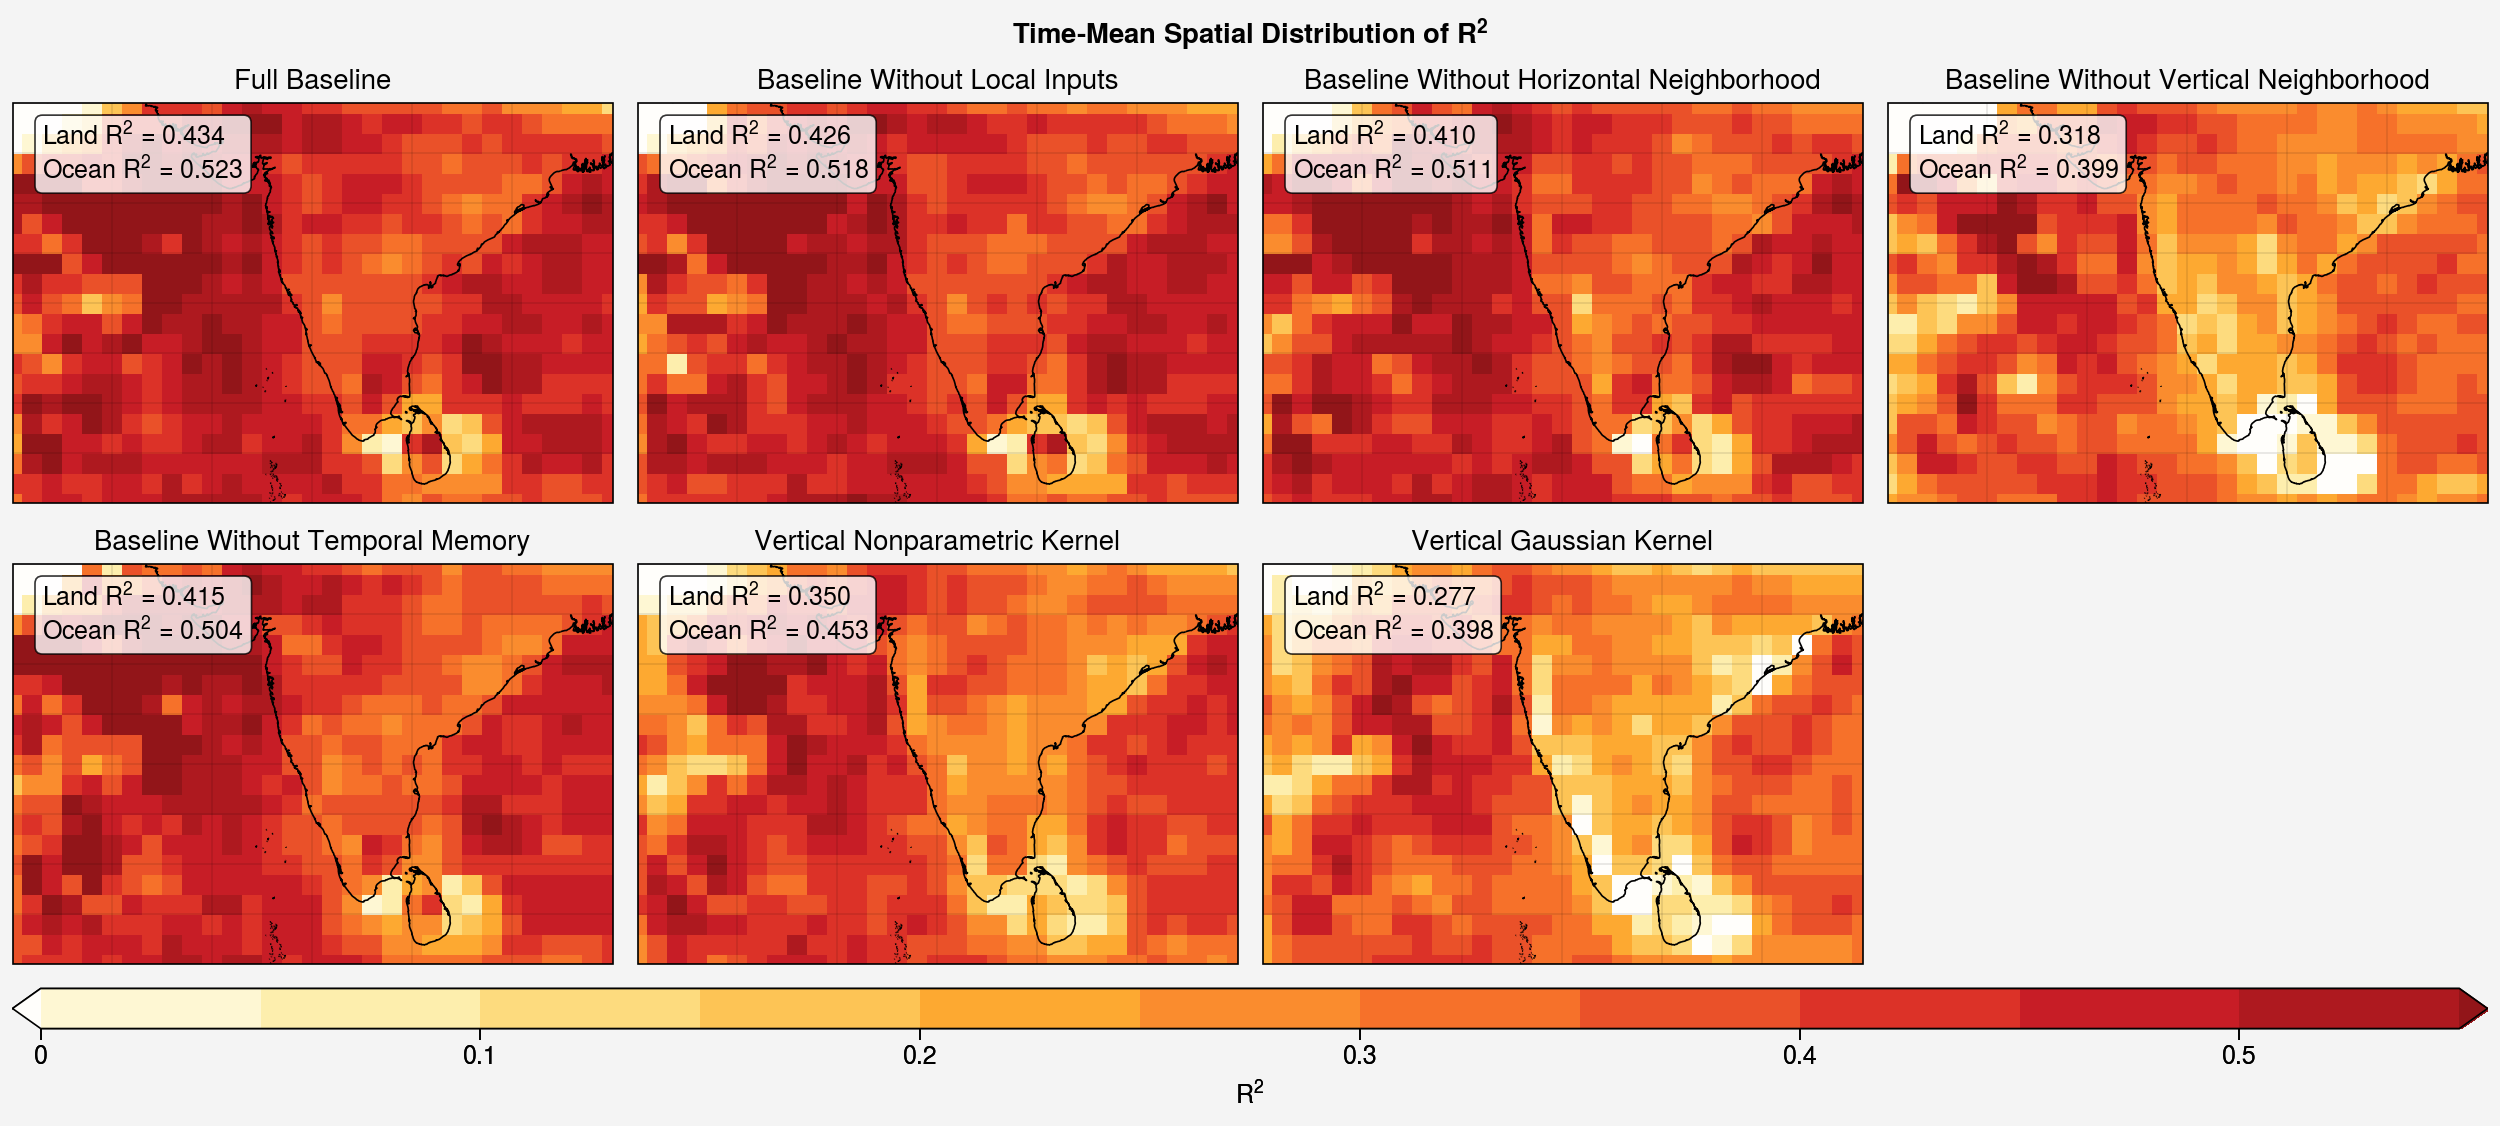

In [23]:
plot_r2_maps(results,nrows,ncols,landfrac)

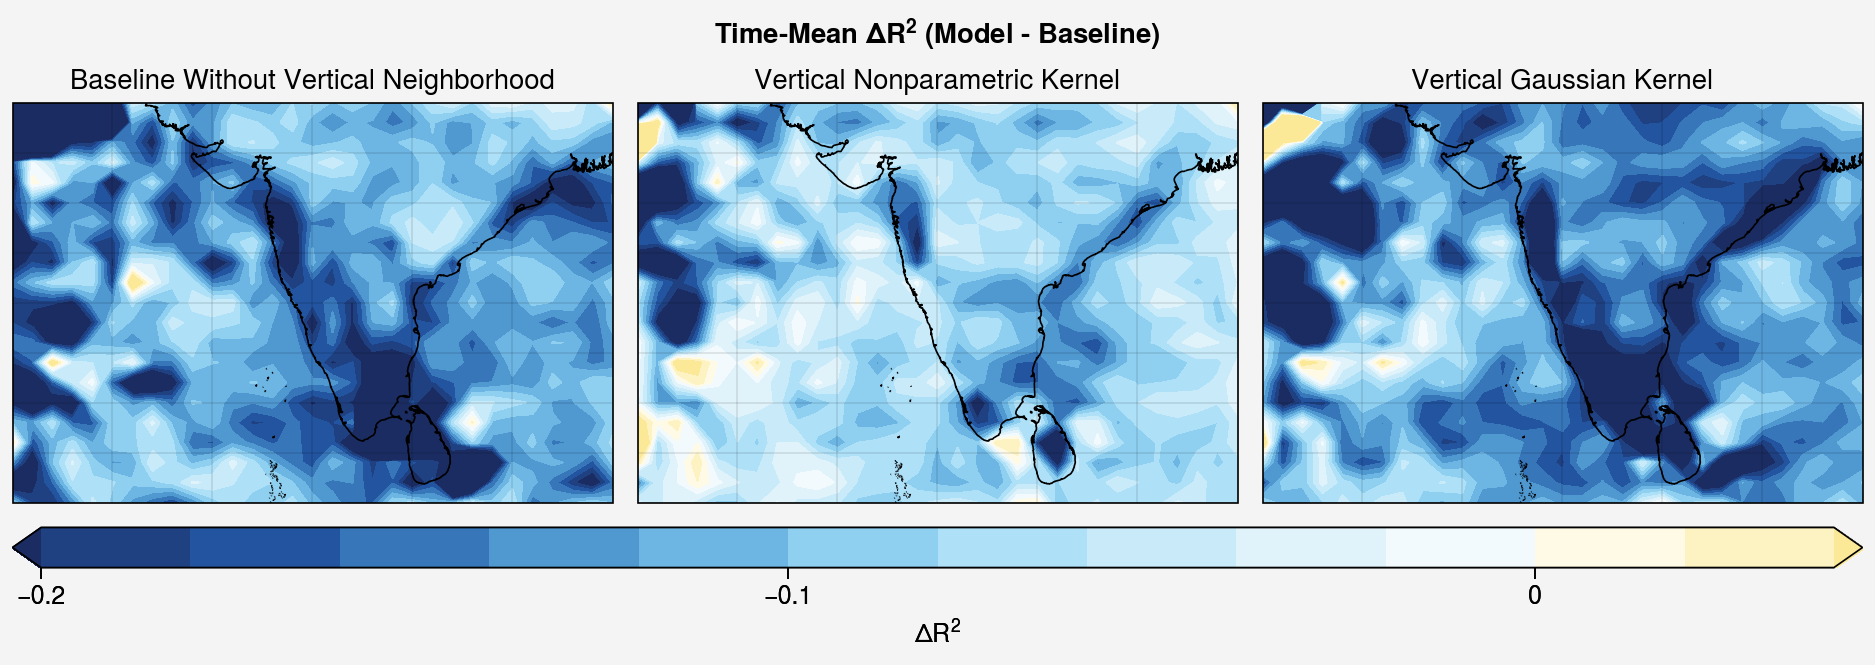

In [33]:
plot_r2_diff_maps(results,nrows-1,ncols-1,landfrac)

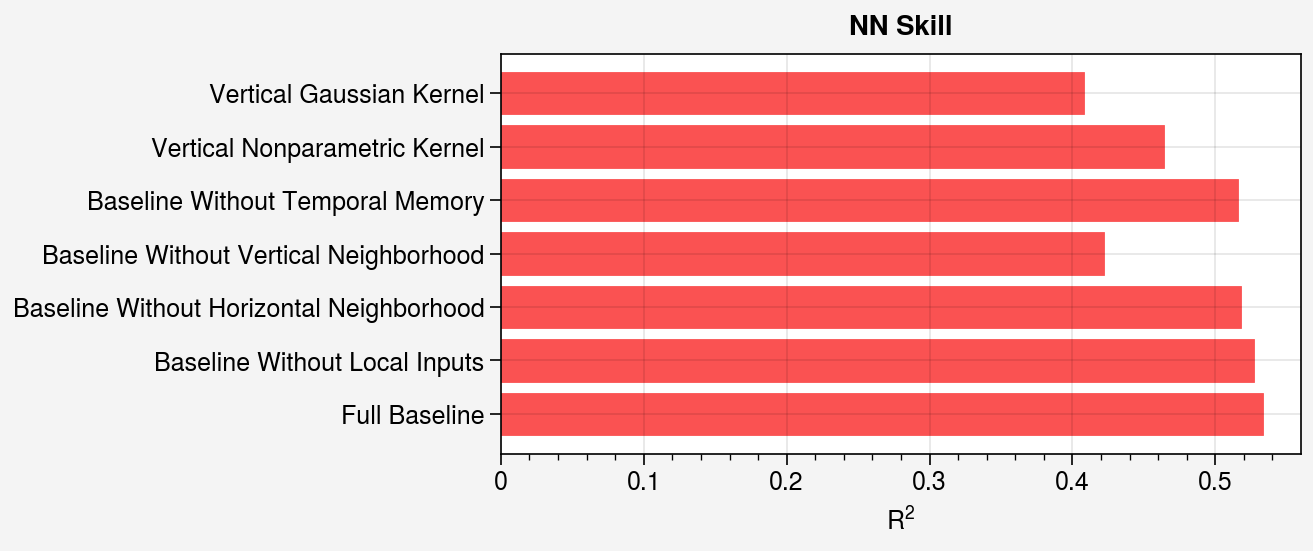

In [25]:
plot_r2_bars(results)

In [39]:
import sys
import os
import torch
from models import build_model_from_config
from data import DataPrep
from utils import Config

sys.path.insert(0, os.path.join('..', 'scripts', 'nn'))
os.chdir('../scripts/nn')
CFG = Config()
os.chdir('../../notebooks') 

FILEDIR = '../data/splits'  
MODELDIR = '../models/nn'  
FIELDVARS = CFG.fieldvars
LOCALVARS = CFG.localvars
TARGETVAR = CFG.targetvar

ds = DataPrep.load('train', FILEDIR)
fielddata,localdata,targetdata = DataPrep.tensors(ds, FIELDVARS, LOCALVARS, TARGETVAR)

if 'quadweights' in ds:
    quadweights = torch.from_numpy(ds['quadweights'].values.astype(np.float32))
    plats, plons, plevs, ptimes = 3,3,16,7  
    quadweights = quadweights[:plats, :plons, :plevs, :ptimes]


nfieldvars = len(FIELDVARS)
nlocalvars = len(LOCALVARS)
patchshape = (plats, plons, plevs, ptimes)


param_cfg = next(m for m in CFG.models if m['name'] == 'gaussian_vertical')
nonparam_cfg = next(m for m in CFG.models if m['name'] == 'nonparametric_vertical')

model_param = build(param_cfg, patchshape, nfieldvars, nlocalvars)
model_nonparam = build(nonparam_cfg, patchshape, nfieldvars, nlocalvars)

IO.get_model(model_param, 'gaussian_vertical', MODELDIR)
IO.get_model(model_nonparam, 'nonparametric_vertical', MODELDIR)

# Get weights
weights_param = model_param.kernellayer.weights(quadweights)
weights_nonparam = model_nonparam.kernellayer.weights(quadweights)

# Plot vertical profiles (average over horizontal/temporal)
vert_param = weights_param.mean(dim=(2,3,5))
vert_nonparam = weights_nonparam.mean(dim=(2,3,5))

nkernels = weights_param.shape[1]
fig, axes = plt.subplots(1, nfieldvars, figsize=(5*nfieldvars, 6))
for f in range(nfieldvars):
    ax = axes[f] if nfieldvars > 1 else axes
    for k in range(nkernels):
        ax.plot(vert_param[f, k, :], label=f'Parametric K{k}', linestyle='-')
        ax.plot(vert_nonparam[f, k, :], label=f'Nonparametric K{k}', linestyle='--')
    ax.set_xlabel('Kernel Weight')
    ax.set_ylabel('Pressure Level')
    ax.set_title(f'{FIELDVARS[f]}')
    ax.legend()
    ax.invert_yaxis()
plt.tight_layout()
plt.show()

NameError: name 'build' is not defined